In [5]:
#FVMB 2020 Exercise 3 Validation notebook
#You can use this notebook to visualise your results
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [6]:
load=torch.load('exercise3_stereo_pytorch.pth')
fixed=load['fixed']
moving=load['moving']
data=load['data']
print('Fixed shape',fixed.shape)
print('Data:\n',data)

Fixed shape torch.Size([370, 447])
Data:
 tensor([[0.5000, 1.0000, 3.0000, 2.5000, 1.5000],
        [3.0000, 3.5000, 1.5000, 0.5000, 2.0000],
        [2.0000, 1.5000, 1.0000, 2.0000, 4.0000],
        [2.0000, 1.0000, 3.0000, 3.5000, 1.0000]])


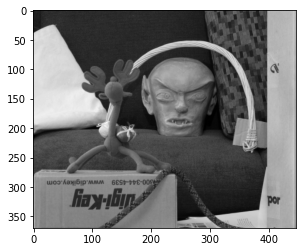

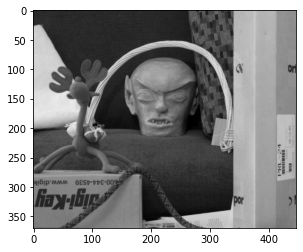

In [7]:
plt.imshow(fixed,'gray')
plt.show()
plt.imshow(moving,'gray')
plt.show()


In [14]:
# Task 1
K = 67
H,W = moving.shape

beta = torch.tensor(0.11)
gamma = torch.tensor(7, dtype=torch.float)
delta = torch.tensor(2, dtype=torch.float)

weight = torch.linspace(-0.5, 0.5, 3)
moving_x = F.conv2d(moving.view(1,1,H,W), weight.view(1,1,1,3), padding=(0,1))
fixed_x = F.conv2d(fixed.view(1,1,H,W), weight.view(1,1,1,3), padding=(0,1))

#fixed_rep = fixed.repeat(1,67,1,1)
#fixed_x_rep = fixed_x.repeat(1,67,1,1)

moving_pad1 = F.pad(moving, (66,0))

print(moving_pad1.shape)
moving_pad = moving_pad1.view(1,1,H, W + K-1)
M1 = F.unfold(moving_pad, (1,67))
print(M1.shape)
M = M1.view(1,K, H, W)

moving_x_pad = F.pad(moving_x, (66,0)).view(1,1,H, W + K-1)
Mx = F.unfold(moving_x_pad, (1,67)).view(1,K, H, W)

dif = torch.abs(fixed - M)
dif_x = torch.abs(fixed_x - Mx)

Dy = beta * torch.where(dif < gamma, dif, gamma) + (1-beta) * torch.where(dif_x < delta, dif_x, delta)
Dy = Dy.squeeze()


torch.Size([370, 513])
torch.Size([1, 67, 165390])


In [9]:
# Task 2 Bsp aus VL

D = torch.tensor([[0.5, 1.0, 3.0, 2.5, 1.5],
                    [3.0, 3.5, 1.5, 0.5, 2.0],
                    [2.0, 1.5, 1.0, 2.0, 4.0], 
                    [2.0, 1.0, 3.0, 3.5, 1.0]])

K_bsp = 5
N_bsp = 4

idx_K = torch.arange(K_bsp).unsqueeze(0).repeat(K_bsp, 1)
idx_K_rev = idx_K.transpose(1,0)
regular = torch.abs(idx_K - idx_K_rev)

# forward path:
forward = torch.zeros_like(D)
forward[0,:] = D[0,:]
b = torch.zeros([K_bsp - 2, K_bsp])

for i in range(0,3):
    all_costs = forward[i,:].repeat(K_bsp,1)+regular
    costs, b_i = torch.min( all_costs , dim=1)
    forward[i+1,:] = D[i+1,:] + costs
    b[i,:] = b_i

#backward path:
backward = torch.zeros_like(D)
backward[-1,:] = D[-1,:]
for i in range(2,-1, -1):
    all_costs = backward[i+1,:].repeat(K_bsp,1)+regular
    costs,_ = torch.min( all_costs , dim=1)
    backward[i,:] = D[i,:] + costs
    

comb_costs = forward + backward - D


In [18]:
# task 3
idx_K = torch.arange(K, dtype=float).unsqueeze(0).repeat(K, 1)
idx_K_rev = idx_K.transpose(1,0)
regular = torch.abs(idx_K - idx_K_rev)
regular = torch.where(regular <= torch.tensor(3.5, dtype=torch.double), regular, torch.tensor(3.5, dtype=torch.double))
regular = regular.unsqueeze(2).repeat(1,1,H)

# forward path:
forward = torch.zeros_like(Dy)
forward[:,:,0] = Dy[:,:,0]
b = torch.zeros([K, H, W])

print(forward[:,:,i].shape)
for i in range(0,W-1):
    all_costs = forward[:,:,i].repeat(K,1,1)+regular
    costs, b_i = torch.min( all_costs , dim=1)
    forward[:,:,i+1] = Dy[:,:,i+1] + costs
    b[:,:,i] = b_i

#backward path:
backward = torch.zeros_like(Dy)
backward[:,:,-1] = Dy[:,:,-1]
for i in range(W-2,-1, -1):
    all_costs = backward[:,:,i+1].repeat(K,1,1)+regular
    costs,_ = torch.min( all_costs , dim=1)
    backward[:,:,i] = Dy[:,:,i] + costs
    

comb_costs = forward + backward - Dy


torch.Size([67, 370])


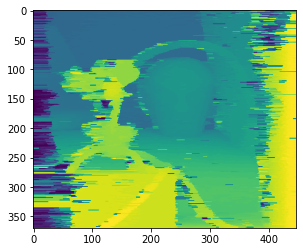

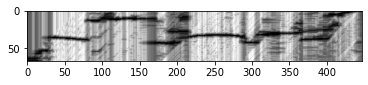

In [11]:
# Find min cost per pix
disparity = torch.argmin(comb_costs, dim=0)

plt.imshow(-disparity)
plt.show()

plt.imshow(comb_costs[:,200,:], cmap="gray")
plt.show()

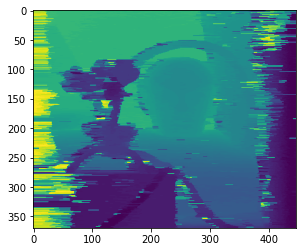

In [19]:
#To visualise with parula colormap
stereo_output=torch.load('stereo_output.pth')
plt.imshow(stereo_output)
plt.show()